In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def uniform_hypersphere(d):
    # sample a point uniformly from d-1 sphere
    x = np.random.randn(d)
    x /= np.linalg.norm(x)
    return x

In [3]:
def y_sample(D, c, X, eps=0.):
    noise = np.random.normal(size=X.shape[0]) * eps
    y = X @ (D @ c) + noise # no noise added
    return y
def X_sample(n, d, distribution_sample, device='cpu'):
    # a n \times d matrix with each row sampled according to function distribution_sample
    X = []
    for i in range(n):
        X.append(distribution_sample(d))
    X = np.array(X)
    if device=='cuda':
        return torch.FloatTensor(X).cuda()
    return X

def c_sample(k, distribution_sample, device='cpu'):
    # a k dimensional vector sampled according to distribution_sample
    c = distribution_sample(k) 
    if device=='cuda':
        return torch.FloatTensor(c).cuda()
    return c

def add_noise(D, eps=0.0):
    return np.random.uniform(-eps, eps, size=D.shape) + D

In [4]:
A = np.random.randn(10, 5)
B = np.random.randn(5)

In [5]:
(B).dot(A.T)

array([-0.3902852 , -2.64351581, -2.72326039,  2.48354257,  1.56584716,
       -3.17266865,  2.29194927,  1.44526425, -0.04444766,  1.07725507])

In [6]:
def task_c_loss_gradient_with_query(X, y, D, X2=None, y2=None, lambd=0., device='cpu'):
    
    if X2 is None:
        X2 = X
        y2 = y
        
    n = X.shape[0]
    p = n
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(X2DD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y2)||^2
#     print(X.shape, X2.shape, D.shape, y.shape, y2.shape)
    A = X @ D # n x k
    A2 = X2 @ D # n2 x k
    AT = A.T # k x n
    A2T = A2.T # k x n2

    AAT = A @ A.T # n x n
    S = inv(AAT + (lambd * I)) # T_0   # n x n

    Sy = S @ y # n x 1
    XTSy = (X.T) @ Sy # t_1 (d x 1)
    c_solved = D.T @ XTSy # k x 1

    pred = A2 @ c_solved # n2 x 1
    err = (pred - y2) # t_2 (n2 x 1)
    
    ATSy = AT @ Sy # t_3 (k x 1)
    X2Terr = X2.T @ err  # t_4 d x 1
    A2Terr = A2T @ err # t_5
    SAA2Terr = S @ (A @ A2Terr)

    functionValue = (norm(err) ** 2)
    gradient = (2 * outer(X2Terr, ATSy))\
            + (2 * outer(XTSy, A2Terr))\
            - (2 * outer(X.T @ SAA2Terr, ATSy))\
            - (2 * outer(XTSy, A.T @ SAA2Terr))


    return c_solved, functionValue / n, gradient / n

In [7]:
def task_c_loss_gradient_without_query(X, y, D, lambd=0., device='cpu'):
    
    n = X.shape[0]
    k = D.shape[1]
    p = min(n,k)
    if device == 'cuda':
        inv = torch.inverse
        outer = torch.ger
        norm = torch.norm
        I = torch.eye(p, p).cuda()
    else:
        inv = np.linalg.inv
        norm = np.linalg.norm
        outer = np.multiply.outer
        I = np.eye(p, p)
    
    # if model is over-parameterized, use Woodburry Identity 
    # ||(XDD.TX.T*(XDD.TX.T+lambd*eye)^{-1}y-y)||^2
    if n < k:
        A = X @ D # n x k
        AT = A.T # k x n
        AAT = A @ A.T # n x n
        S = inv(AAT + (lambd * I)) # T_0   # n x n
        Sy = S @ y # n x 1
        XTSy = (X.T) @ Sy # t_1 (d x 1)
        c_solved = D.T @ XTSy # k x 1
        pred = AAT @ Sy # n x 1
        err = (pred - y) # t_2 (n x 1)
        ATSy = AT @ Sy # t_3 (k x 1)
        XTerr = X.T @ err  # t_4 d x 1
        ATerr = AT @ err
        SAATerr = S @ (A @ ATerr)

        functionValue = (norm(err) ** 2)
        gradient = (2 * outer(XTerr, ATSy))\
                + (2 * outer(XTSy, ATerr))\
                - (2 * outer(X.T @ SAATerr, ATSy))\
                - (2 * outer(XTSy, A.T @ SAATerr))

    else:    
        # ||((D.TX.TXD+lambd*eye)^{-1}D.TX.Ty-y)||^2
        S = inv((D.T@X.T)@(X@D) + (lambd * I))
        XTy = (X.T) @ y
        DTXTy = D.T @ XTy
        c_solved = S @ (DTXTy)
        pred = X @ (D @ c_solved)
        S_1 = (pred - y)
        S_2 = X.T @ S_1
        S_3 = S @ D.T @ X.T @ S_1

        functionValue = (norm(S_1) ** 2)
        gradient = 2 * (outer(S_2, c_solved))\
                    - 2* ((outer(X.T @ pred, S_3)) + (outer((X.T @ (X @ (D @ (S @ (D.T @ S_2))))), c_solved)))\
                    + (2 * outer(XTy, S_3))

    return c_solved, functionValue / n, gradient / n



In [8]:
def train_without_query(n, d, k_actual, D_true, D_test, D_init, X_pool, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    
    for iteration in tqdm(range(1, num_iterations+1), total=num_iterations):
        X = X_pool[np.random.choice(len(X_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # test evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.0
            n_test = 100
            n_train = 100
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
                
            for i in range(n_test):
                X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
                c = c_sample(k_actual, distribution_sample=uniform_hypersphere, device=device)
                y = y_sample(D=D_test, c=c, X=X)
                c_solved, loss, gradient = task_c_loss_gradient_without_query(X=X, y=y, D=D, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D
        


In [24]:
def train_with_query(n, n2, d, k_actual, D_true, D_test, D_init, X_pool, Xq_pool, c_pool, lambd, lr, num_iterations_train, test_frequency, device, batchsz):
    D = D_init
    num_iterations = num_iterations_train
    avg_train_loss = []
    avg_test_loss = []
    grads = []
    
    for iteration in tqdm(range(1, num_iterations+1), total=num_iterations):
        X = X_pool[np.random.choice(len(X_pool))]
        Xq = Xq_pool[np.random.choice(len(Xq_pool))]
        c = c_pool[np.random.choice(len(c_pool))]
        y = y_sample(D=D_true, c=c, X=X, eps=0.)
        yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
        c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
        grads.append(gradient)
        
        # batch update
        if iteration % batchsz == 0:
            D = D - lr * np.mean(grads, 0) # update the loss
            grads = []
            
        if iteration % test_frequency == 0: # test evaluation
            sum_train_loss = 0.
            sum_test_loss = 0.
            n_test = 100
            n_train = 100
            
            for i in range(n_train):
                X = X_pool[np.random.choice(len(X_pool))]
                Xq = Xq_pool[np.random.choice(len(Xq_pool))]
                c = c_pool[np.random.choice(len(c_pool))]
                y = y_sample(D=D_true, c=c, X=X, eps=0.)
                yq = y_sample(D=D_true, c=c, X=Xq, eps=0.)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_train_loss += loss
            avg_train_loss.append(sum_train_loss / n_train)
     
            for i in range(n_test):
                X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
                Xq = X_sample(n=n2, d=d, distribution_sample=uniform_hypersphere, device=device)
                c = c_sample(k_actual, distribution_sample=uniform_hypersphere, device=device)
                y = y_sample(D=D_test, c=c, X=X)
                yq = y_sample(D=D_test, c=c, X=Xq)
                c_solved, loss, gradient = task_c_loss_gradient_with_query(X=X, y=y, D=D, X2=Xq, y2=yq, lambd=lambd, device=device)
                sum_test_loss += loss
            avg_test_loss.append(sum_test_loss / n_test)
            
    return avg_train_loss, avg_test_loss, D

100%|██████████| 100000/100000 [01:14<00:00, 1340.90it/s]


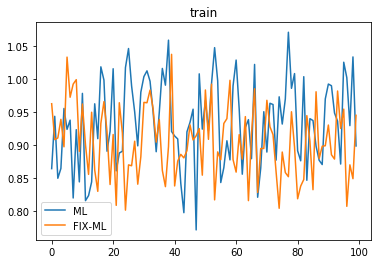

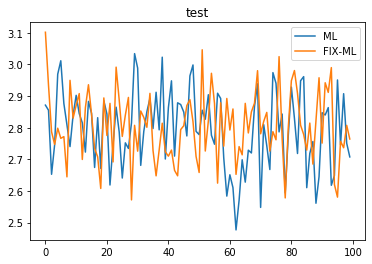

In [29]:
########### THIS IS A TYPICAL RUN ###########

# Set parameters
n = 5 # number of support examples per task
n2 = 15 # number of query examples per task
d = 100 # ambient dimension
k = 50 # subspace dimension we learn (used in prediction)
k_actual = 10 # actual subspace dimension of the weights (used in data generation)  
T = 10000 # total number of tasks
M = 10000 # total number of X matrix of shape n \times d
m = 1 # totatl number of fixML's matrix X
lr = 0.001 # learning rate for learning D
num_iterations_train = 100000 # no of train_iterations
test_frequency = 1000 # no of iterations after which we test
batchsz = 1
lambd = 10. # inner loop regularizer
device = 'cpu' # cuda uses GPU, cpu option would only perform operations on np arrays
seed = 42

# Get Dataset
np.random.seed(seed)
X_pool = [X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device) for i in range(M)]
X_fix_pool = X_pool[:m]
c_pool = [c_sample(k_actual, distribution_sample=uniform_hypersphere, device=device) for i in range(T)]
Xq_pool = [X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device) for i in range(T)]


# obtain meta-learning and fix-meta learning solns
D_true = np.random.randn(d, k_actual)
D_init = np.random.randn(d, k)
D_test = add_noise(D_true, eps=0.)


if device == 'cuda':
    D_true = torch.FloatTensor(D_true).cuda()
    D_init = torch.FloatTensor(D_init).cuda()
    D_test = torch.FloatTensor(D_test).cuda()


np.random.seed(seed)
metal_avg_train_loss, metal_avg_test_loss, D_ML = train_with_query(n=n, n2=n2, d=d, k_actual=k_actual, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_pool, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)
np.random.seed(seed)
fix_metal_avg_train_loss, fix_metal_avg_test_loss, D_FIXML = train_with_query(n=n, n2=n2, d=d, k_actual=k_actual, D_true=D_true, D_test=D_test, D_init=D_init, X_pool=X_fix_pool, Xq_pool=Xq_pool, c_pool=c_pool, lambd=lambd, lr=lr, num_iterations_train=num_iterations_train, test_frequency=test_frequency, device=device, batchsz=batchsz)

# plots
plt.plot(list(range(len(metal_avg_train_loss))), metal_avg_train_loss, label='ML')
plt.plot(list(range(len(fix_metal_avg_train_loss))), fix_metal_avg_train_loss, label='FIX-ML')
plt.title('train')
plt.legend()
plt.show()

plt.plot(list(range(num_iterations_train // test_frequency)), metal_avg_test_loss, label='ML')
plt.plot(list(range(num_iterations_train // test_frequency)), fix_metal_avg_test_loss, label='FIX-ML')
plt.title('test')
plt.legend()
plt.show()

In [11]:
for k in range(1, 10):
    print('--'*50)
    print(k)
#     D_test = np.concatenate([D_true[:, :-k], np.random.randn(d, k+20)], axis=1)
    D_test = np.random.randn(d, k_actual+200)
    print(D_test.shape)
    D = D_ML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k_actual+200, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        c_solved, loss, gradient = task_c_loss_gradient_without_query(X, y, D, lambd, device)
        sum_test_loss += loss
    print(sum_test_loss / n_test)

    D = D_FIXML
    sum_test_loss = 0.
    n_test = 2000
    for i in range(n_test):
        X = X_sample(n=n, d=d, distribution_sample=uniform_hypersphere, device=device)
        c = c_sample(k_actual+200, distribution_sample=uniform_hypersphere, device=device)
        y = y_sample(D=D_test, c=c, X=X)
        c_solved, loss, gradient = task_c_loss_gradient_without_query(X, y, D, lambd, device)
        sum_test_loss += loss
    print(sum_test_loss / n_test)

----------------------------------------------------------------------------------------------------
1
(100, 210)
0.0005699182515596429


KeyboardInterrupt: 

In [ ]:
from __future__ import division, print_function, absolute_import

import numpy as np

def fAndG(D, X, c, y):
    assert isinstance(D, np.ndarray)
    dim = D.shape
    assert len(dim) == 2
    D_rows = dim[0]
    D_cols = dim[1]
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1, )
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert y_rows == X_rows
    assert X_cols == D_rows
    
    
    
    _, functionValue, gradient = task_c_loss_gradient_without_query(X, y, D, lambd=c)
    
#     lambd = c
#     k = X.shape[0] 
#     inv = np.linalg.inv
#     norm = np.linalg.norm
#     outer = np.multiply.outer
#     I = np.eye(k, k)
    
    
    
#     A = X @ D # n x k
#     AT = A.T # k x n
#     AAT = A @ A.T # n x n
#     S = inv(AAT + (lambd * I)) # T_0   # n x n
#     Sy = S @ y # n x 1
#     XTSy = (X.T) @ Sy # t_1 (d x 1)
#     c_solved = D.T @ XTSy # k x 1
#     pred = AAT @ Sy # n x 1
#     err = (pred - y) # t_2 (n x 1)
#     ATSy = AT @ Sy # t_3 (k x 1)
#     XTerr = X.T @ err  # t_4 d x 1
#     ATerr = AT @ err
#     SAATerr = S @ (A @ ATerr)
    
#     functionValue = (np.linalg.norm(err) ** 2)
#     gradient_old = (2 * np.multiply.outer(XTerr, ATSy))\
#             + (2 * np.multiply.outer(XTSy, ATerr))\
#             - (2 * np.multiply.outer(X.T @ SAATerr, ATSy))\
#             - (2 * np.multiply.outer(XTSy, A.T @ SAATerr))

#     _, functionValue, gradient_old = task_c_loss_gradient_without_query(X, y, D, lambd=c)
    
#     T_0 = np.linalg.inv(((((X).dot(D)).dot(D.T)).dot(X.T) + (c * np.eye(y_rows, y_rows))))
#     t_1 = (X.T).dot((T_0).dot(y))
#     t_2 = ((X).dot((D).dot((D.T).dot(t_1))) - y)
#     t_3 = (((y).dot(T_0)).dot(X)).dot(D)
#     t_4 = (X.T).dot(t_2)
#     t_5 = (((((t_3).dot(D.T)).dot(X.T) + -y)).dot(X)).dot(D)

#     print("T_0", np.linalg.norm(S-T_0))
#     print("t_1", np.linalg.norm(t_1-XTSy))
#     print("t_2", np.linalg.norm(t_2-err))
#     print("t_3", np.linalg.norm(t_3-ATSy))
#     print("t_4", np.linalg.norm(t_4-XTerr))
#     print("t_5", np.linalg.norm(t_5-ATerr))
#     print("1", np.linalg.norm(np.multiply.outer(X.T @ SAATerr, ATSy)-np.multiply.outer((X.T).dot((T_0).dot((X).dot((D).dot((D.T).dot(t_4))))), t_3)) )
#     print("2", np.linalg.norm(np.multiply.outer(XTSy, A.T @ SAATerr)-np.multiply.outer(t_1, (((((t_5).dot(D.T)).dot(X.T)).dot(T_0)).dot(X)).dot(D)) ))
#     print("3", np.linalg.norm(np.multiply.outer(XTerr, ATSy) - np.multiply.outer(t_4, t_3)))
#     print("4", np.linalg.norm(np.multiply.outer(XTSy, ATerr) - np.multiply.outer(t_1, t_5)))
    
#     print("val", np.linalg.norm(t_2) ** 2 - (np.linalg.norm(err) ** 2))
# #     functionValue = (np.linalg.norm(t_2) ** 2)
#     gradient = (2 * np.multiply.outer(t_4, t_3))\
#     + (2 * np.multiply.outer(t_1, t_5))\
#     - (2 * np.multiply.outer((X.T).dot((T_0).dot((X).dot((D).dot((D.T).dot(t_4))))), t_3))\
#     - (2 * np.multiply.outer(t_1, (((((t_5).dot(D.T)).dot(X.T)).dot(T_0)).dot(X)).dot(D)))
#     print("G", np.linalg.norm(gradient_old-gradient))
    return functionValue, gradient

def checkGradient(D, X, c, y):
    # numerical gradient checking
    # f(x + t * delta) - f(x - t * delta) / (2t)
    # should be roughly equal to inner product <g, delta>
    t = 1E-6
    delta = np.random.randn(*(D.shape))
    f1, _ = fAndG(D + t * delta, X, c, y)
    f2, _ = fAndG(D - t * delta, X, c, y)
    f, g = fAndG(D, X, c, y)
    print('approximation error',
          np.linalg.norm((f1 - f2) / (2*t) - np.tensordot(g, delta, axes=2)))

def generateRandomData():
    D = np.random.randn(5, 100)
    X = np.random.randn(100, 5)
    c = np.random.randn(1)
    c = 0.01
    y = np.random.randn(100)

    return D, X, c, y

if __name__ == '__main__':
    D, X, c, y = generateRandomData()
    functionValue, gradient = fAndG(D, X, c, y)
    print('functionValue = ', functionValue)
    print('gradient = ', gradient)

    print('numerical gradient checking ...')
    checkGradient(D, X, c, y)


In [ ]:
"""
Sample code automatically generated on 2020-10-20 07:25:50

by www.matrixcalculus.org

from input

d/dD norm2(X2*D*D'*X'*inv(X*D*D'*X' + c*eye)*y - y2)^2 = 2*X2'*(X2*D*D'*X'*inv(X*D*D'*X'+c*eye)*y-y2)*(y'*inv(X*D*D'*X'+c*eye)*X*D)+2*X'*inv(X*D*D'*X'+c*eye)*y*((y'*inv(X*D*D'*X'+c*eye)*X*D*D'*X2'+(-y2)')*X2*D)-(2*X'*inv(X*D*D'*X'+c*eye)*X*D*D'*X2'*(X2*D*D'*X'*inv(X*D*D'*X'+c*eye)*y-y2)*(y'*inv(X*D*D'*X'+c*eye)*X*D)+2*X'*inv(X*D*D'*X'+c*eye)*y*((y'*inv(X*D*D'*X'+c*eye)*X*D*D'*X2'+(-y2)')*X2*D*D'*X'*inv(X*D*D'*X'+c*eye)*X*D))

where

D is a matrix
X is a matrix
X2 is a matrix
c is a scalar
y is a vector
y2 is a vector

The generated code is provided "as is" without warranty of any kind.
"""

from __future__ import division, print_function, absolute_import

import numpy as np

def fAndG(D, X, X2, c, y, y2):
    assert isinstance(D, np.ndarray)
    dim = D.shape
    assert len(dim) == 2
    D_rows = dim[0]
    D_cols = dim[1]
    assert isinstance(X, np.ndarray)
    dim = X.shape
    assert len(dim) == 2
    X_rows = dim[0]
    X_cols = dim[1]
    assert isinstance(X2, np.ndarray)
    dim = X2.shape
    assert len(dim) == 2
    X2_rows = dim[0]
    X2_cols = dim[1]
    if isinstance(c, np.ndarray):
        dim = c.shape
        assert dim == (1, )
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert isinstance(y2, np.ndarray)
    dim = y2.shape
    assert len(dim) == 1
    y2_rows = dim[0]
    assert y2_rows == X2_rows
    assert D_rows == X_cols == X2_cols
    assert y_rows == X_rows

    
    _, functionValue, gradient = task_c_loss_gradient_with_query(X, y, D, X2, y2, lambd=c)
    
#     T_0 = np.linalg.inv(((((X).dot(D)).dot(D.T)).dot(X.T) + (c * np.eye(y_rows, y_rows))))
#     t_1 = (X.T).dot((T_0).dot(y))
#     t_2 = ((X2).dot((D).dot((D.T).dot(t_1))) - y2)
#     t_3 = (((y).dot(T_0)).dot(X)).dot(D)
#     t_4 = (X2.T).dot(t_2)
#     t_5 = (((((t_3).dot(D.T)).dot(X2.T) + -y2)).dot(X2)).dot(D)
#     functionValue = (np.linalg.norm(t_2) ** 2)
#     gradient = (((2 * np.multiply.outer(t_4, t_3)) + (2 * np.multiply.outer(t_1, t_5))) - ((2 * np.multiply.outer((X.T).dot((T_0).dot((X).dot((D).dot((D.T).dot(t_4))))), t_3)) + (2 * np.multiply.outer(t_1, (((((t_5).dot(D.T)).dot(X.T)).dot(T_0)).dot(X)).dot(D)))))

    return functionValue, gradient

def checkGradient(D, X, X2, c, y, y2):
    # numerical gradient checking
    # f(x + t * delta) - f(x - t * delta) / (2t)
    # should be roughly equal to inner product <g, delta>
    t = 1E-6
    delta = np.random.randn(*D.shape)
    f1, _ = fAndG(D + t * delta, X, X2, c, y, y2)
    f2, _ = fAndG(D - t * delta, X, X2, c, y, y2)
    f, g = fAndG(D, X, X2, c, y, y2)
    print('approximation error',
          np.linalg.norm((f1 - f2) / (2*t) - np.tensordot(g, delta, axes=2)))

def generateRandomData():
    D = np.random.randn(30, 10)
    X = np.random.randn(5, 30)
    X2 = np.random.randn(100, 30)
    c = np.random.randn(1)
    y = np.random.randn(5)
    y2 = np.random.randn(100)

    return D, X, X2, c, y, y2

if __name__ == '__main__':
    D, X, X2, c, y, y2 = generateRandomData()
    functionValue, gradient = fAndG(D, X, X2, c, y, y2)
    print('functionValue = ', functionValue)
#     print('gradient = ', gradient)

    print('numerical gradient checking ...')
    checkGradient(D, X, X2, c, y, y2)
